In [1]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF

In [2]:
# Lorenz96
# J: dim of state space
J = 40

# F: forcing
F = 8



In [3]:
# generate data
# dt: time step size
dt = 0.01

# N: number of time step, 2 years : 360*20*2
N = 360*20*2 

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
p = (F,) # parameters
scheme = rk4

result = np.zeros((N,len(x0)))
x = x0
result[0] = x[:]

for n in range(1,N):
    t = n*dt
    x = scheme(lorenz96, t, x, p, dt)
    result[n] = x[:]


x_true = result[360*20:][::5] # spin up 1 year and save per 6 hours
print(x_true.shape)
np.save(f"x_true_l96", x_true)

(1440, 40)


In [4]:
# assimilation period
Dt = 0.05

# Model function for EnKF
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz96, 0, x, p, 0.01)
    return x

# 観測
H = np.eye(J)
# dim_y = 30
# H = np.zeros((dim_y, J))
# H[::4, ::4] = 0

# Model error covariance
Q = np.zeros((J, J))

# Observation error covariance
r = 1.0
R = r*np.eye(J)

# random seed
seed = 0
np.random.seed(seed)

# generate observation
end_step = 500 # for development
x_true = np.load('x_true_l96.npy')[:end_step]
# y = np.load('x_obs_l96.npy')[:end_step]
# if not np.isclose(r, 1.0):
y = (H@x_true.T).T
y += np.random.normal(loc=0, scale=np.sqrt(r), size=y.shape) # R = r*I

# initial state for EnKF
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 25*np.eye(J)


In [5]:
# RUN DA
m = 25
X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
# RUN DA
etkf = ETKF(M, H, R, alpha=1.0, store_ensemble=True)
etkf.initialize(X_0)
for y_obs in y:
    etkf.forecast(Dt)
    etkf.update(y_obs)

x_assim = etkf.x

In [6]:
# RUN DA
alpha = 1.2
m = 25
X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
# RUN DA
etkf_alpha = ETKF(M, H, R, alpha=alpha, store_ensemble=True)
etkf_alpha.initialize(X_0)
for y_obs in y:
    etkf_alpha.forecast(Dt)
    etkf_alpha.update(y_obs)

x_assim_alpha = etkf_alpha.x

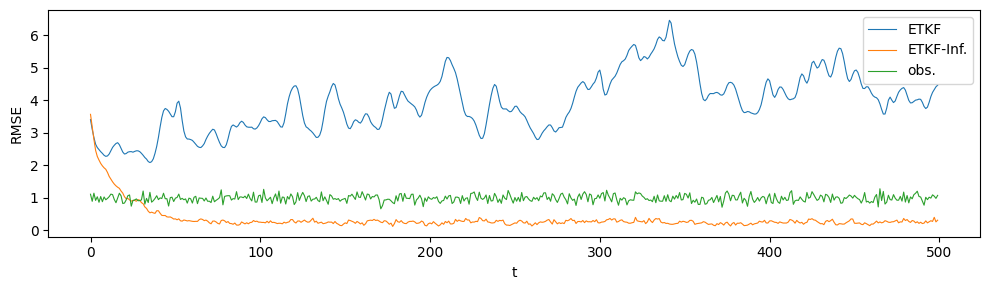

In [7]:
# Plot
fig, ax = plt.subplots(figsize=(10, 3))
plot_loss(x_true, x_assim, loss_rms, ax=ax, label='ETKF', lw=0.8)
plot_loss(x_true, x_assim_alpha, loss_rms, ax=ax, label='ETKF-Inf.', lw=0.8)
plot_loss((H@x_true.T).T, y, loss_rms, ax=ax, label='obs.', lw=0.8)
ax.set_xlabel('t')
ax.set_ylabel('RMSE')
ax.legend()
# ax.set_ylim([0, 2])
fig.tight_layout()
fig.savefig("etkf_inflation_result.pdf")

In [13]:
def compute_cov(X_f):
    return np.array([np.cov(X_ft.T) for X_ft in X_f])

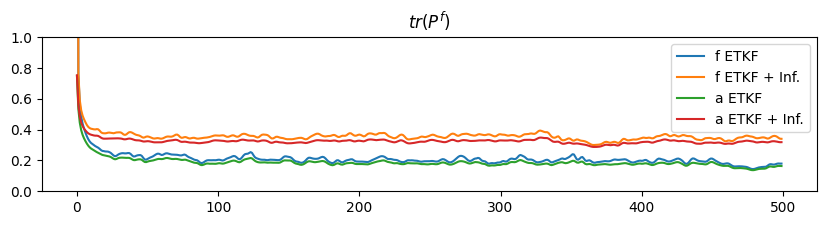

In [14]:
X_a = np.array(etkf.X_a)
C_a = compute_cov(X_a)
X_a_alpha = np.array(etkf_alpha.X_a)
C_a_alpha = compute_cov(X_a_alpha)

X_f = np.array(etkf.X_f)
C_f = compute_cov(X_f)
X_f_alpha = np.array(etkf_alpha.X_f)
C_f_alpha = compute_cov(X_f_alpha)

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(np.sqrt(np.trace(np.array(C_f), axis1=1, axis2=2)/J), label="f ETKF")
ax.plot(np.sqrt(np.trace(np.array(C_f_alpha), axis1=1, axis2=2)/J), label="f ETKF + Inf.")
ax.plot(np.sqrt(np.trace(np.array(C_a), axis1=1, axis2=2)/J), label="a ETKF")
ax.plot(np.sqrt(np.trace(np.array(C_a_alpha), axis1=1, axis2=2)/J), label="a ETKF + Inf.")
ax.set_ylim([0, 1])
ax.set_title("$tr(P^f)$")
plt.legend()

/Users/takeda/Documents/code/da_py/.venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


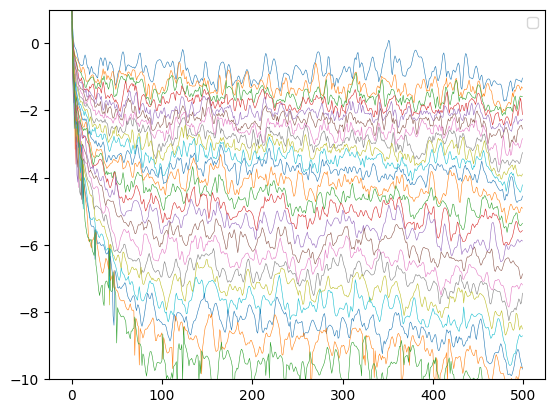

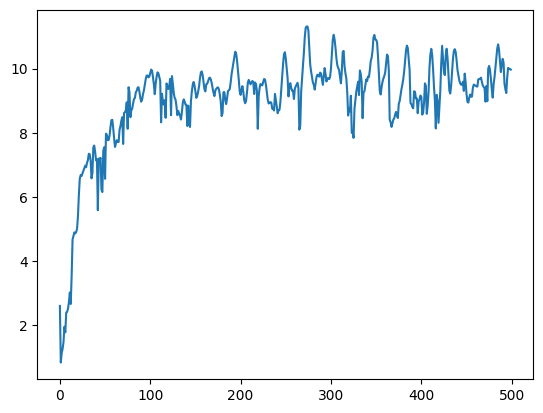

In [15]:
import scipy as sp

evals = np.array([sp.linalg.eigvals(C_ft) for C_ft in C_f])
logevals = np.log(evals)
plt.plot(logevals[:, :23], lw=0.4)
plt.legend()
plt.ylim(-10, 1)
plt.show()

range_logevals = logevals[:, 0] - logevals[:, 23]
plt.plot(range_logevals)
# plt.ylim(0, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


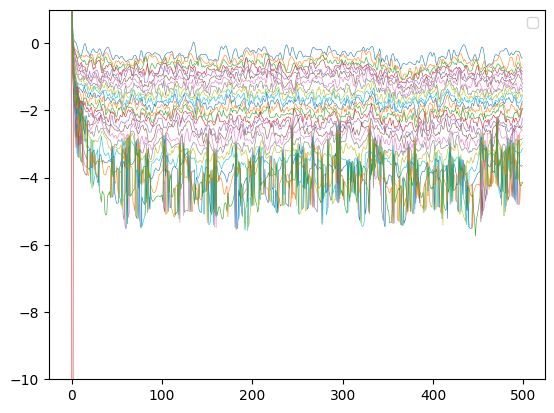

(0.0, 5.68951629817204)

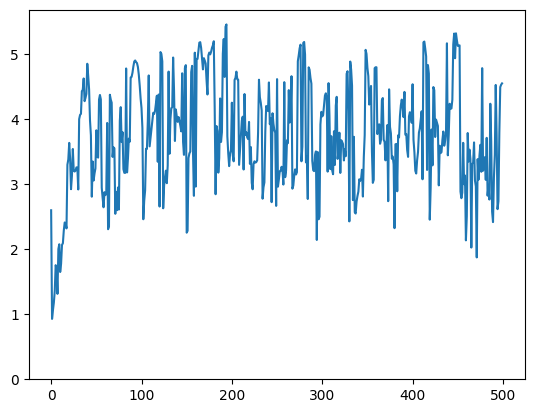

In [16]:
evals_alpha = np.array([sp.linalg.eigvals(C_ft) for C_ft in C_f_alpha])
logevals_alpha = np.log(evals_alpha)
plt.plot(logevals_alpha[:, :23], lw=0.4)
plt.legend()
plt.ylim(-10, 1)

plt.show()


range_logevals_alpha = logevals_alpha[:, 0] - logevals_alpha[:, 23]
plt.plot(range_logevals_alpha)
plt.ylim(0)

In [230]:
logevals_alpha[100, 24]

(-37.344613784305274+0.39010073152758573j)